# Simulating a Year of Observations w/ MeerKAT LSPs 



In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize='medium', direction = 'in')
plt.rc('ytick', labelsize='medium', direction = 'in')

In [2]:
cred = {
          'drivername': 'mysql',
          'username': 'root',
          'password': 'mysql_pass',
          'host': 'localhost',
          'database': 'observations'
}

In [3]:
db = URL(**cred)
engine = create_engine(name_or_url = db)
conn = engine.connect()

In [4]:
query = 'SELECT DISTINCT project FROM target_list;'
lsps = pd.read_sql(query, conn)
lsps = lsps[lsps['project'] != 'Volume Complete'].to_numpy().ravel()

In [5]:
lsps

array(['Fornax', 'LADUMA', 'MeertTime1000', 'MeertTimeGC',
       'MeerTime Binaries', 'MeerTime MSP PPTA', 'MeerTime MSP Nanograv',
       'MeerTime MSP MSPs <-35 decl', 'MeerTime MSP Possible MSP targets',
       'MHONGOOSE', 'MIGHTEE', 'TRAPUM_GC', 'TRAPUM Fermi Sources',
       'TRAPUM Nearby Galaxies'], dtype=object)

## Survey w/ Single Pointing

### LADUMA

This is going to be a pain in the ass to do these all at once, so let's just stick to one project for now. Single pointing

In [6]:
query = 'SELECT * FROM target_list WHERE project = "{}"'.format('LADUMA')
tb = pd.read_sql(query, conn)

In [7]:
points = pd.read_csv('../data/laduma.csv')

In [8]:
points.loc[:, ['ra_deg', 'dec_deg']]

,ra_deg,dec_deg
0,53.12,-28.13


In [9]:
tb = tb.loc[:, ['ra', 'decl']]

LADUMA has 3424 hours in a single field. 

In [10]:
n_beams = 10
obs_length = 5. * 60.
field_time = 3424 * 60. * 60.

potential_obs = n_beams * (field_time / obs_length)
print (
'Given {} beams and a {} second observation time, \
we can observe {} sources. This field has {} sources.\
'.format(n_beams, obs_length, potential_obs, tb.shape[0]))

Given 10 beams and a 300.0 second observation time, we can observe 410880.0 sources. This field has 1597 sources.


In [11]:
potential_obs / tb.shape[0]

257.28240450845334

## Survey w/ Multiple Pointings

### MeerTime GC

In [12]:
query = 'SELECT * FROM target_list WHERE project = "{}"'.format('MeertTimeGC')
tb = pd.read_sql(query, conn).loc[:, ['ra', 'decl']]
points = pd.read_csv('../data/MeerTime_GC_targets.csv').loc[:, ['ra_deg', 'dec_deg']]

In [13]:
id_n = points.shape[0]
kmeans = KMeans(n_clusters=id_n).fit(tb)
id_label = kmeans.labels_

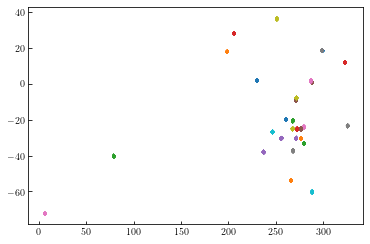

In [14]:
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.scatter(tb.ra[cluster].values, tb.decl[cluster].values, s = 0.1)
plt.show()

In [15]:
targs = []

for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    targs.append(tb.loc[cluster, :])

Assume equal observing time on each pointing. Trapum Fermi observations have ~0.5 hours per pointing

In [16]:
n_beams = 20
obs_length = 5. * 60
field_time = 55 * 60. * 60.
fields = []

potential_obs = n_beams * (field_time / obs_length)

for i in range(len(targs)):
    fields.append(len(targs[i]))

for i in range(len(targs)):
    #fields[i] -= potential_obs
    if potential_obs / fields[i] > 1.0:
        print (i, potential_obs / fields[i])

0 6.41399416909621
1 11.68141592920354
2 14.505494505494505
3 29.398663697104677
4 7.177814029363785
5 6.291706387035272
6 42.99674267100977
7 24.765478424015008
8 19.730941704035875
9 16.879795396419436
10 21.498371335504885
11 9.179415855354659
12 12.878048780487806
13 21.96339434276206
14 7.956600361663653
15 16.438356164383563
16 7.317073170731708
17 6.69710806697108
18 6.969376979936642
19 16.730038022813687
20 9.428571428571429
21 31.961259079903147
22 5.866666666666666
23 6.776180698151951
24 9.455587392550143
25 7.177814029363785
26 7.482993197278912
27 6.238185255198488
28 21.428571428571427


## All Projects

Need to include MIGHTEE, MeerTime 1000, and MeerTime MSP

In [17]:
query = 'SELECT DISTINCT project FROM target_list;'
lsps = pd.read_sql(query, conn)
lsps = lsps[lsps['project'] != 'Volume Complete'].to_numpy().ravel()
lsps = np.array(list(lsps[:5]) + list(lsps[9:]))
lsps = np.delete(lsps, 6)

In [18]:
p_files = [
    'fornax.csv', 'laduma.csv', 'meertime_1000PTA_1000brightest_targets.csv', 
    'MeerTime_GC_targets.csv', 'MeerTime_binaries_atnfcatalog_notgc.csv', 
    'mhongoose_webtable.csv', 'Trapum_GC_targets.csv', 
    'Trapum_fermi_targets.csv', 'trapum_galaxies.csv'    
]

In [19]:
p_data = []

for f in p_files:
    f = '../pointing_data/' + f
    p_data.append(pd.read_csv(f))

In [20]:
# Time per pointing in seconds
# Some of these times don't make sense MeerTime Binary in particular
times = np.array([10. * 91., 3424.,  12 * 1./6., 18 * 2., 18 * 0.5, 
                  55., 2 * 4., 0.5, 20.]) * 60. * 60.

In [21]:
n_beams = 60
pointings = 10
obs_time = 5 * 60.

In [22]:
times

array([3.27600e+06, 1.23264e+07, 7.20000e+03, 1.29600e+05, 3.24000e+04,
       1.98000e+05, 2.88000e+04, 1.80000e+03, 7.20000e+04])

In [23]:
projects = []

for p in lsps:
    query = 'SELECT ra, decl FROM target_list WHERE project = "{}"'.format(p)
    projects.append(pd.read_sql(query, conn))

In [ ]:
# For each LSP

sources_per_group = []

for i, p in enumerate(projects):
    # For each pointing in the lsp, do a thing
    
    points = p_data[i].loc[:, ['ra_deg', 'dec_deg']]
    id_n = points.shape[0]
    print (i, p_files[i])
    if id_n < 800:
        
        kmeans = KMeans(n_clusters = id_n).fit(p)
        id_label = kmeans.labels_
        groups = []
        
        """
        for i in range(id_n):
            cluster=np.where(id_label==i)[0]
            plt.scatter(p.ra[cluster].values, p.decl[cluster].values, s = 0.1)
        plt.show()
        """
        
        for l in np.unique(kmeans.labels_):
            groups.append(len(np.where(kmeans.labels_ == l)[0]))
            
        sources_per_group.append(np.array(groups))
        
        

    else:
        sources_per_group.append([])
        print (p_files[i], id_n)

0 fornax.csv
1 laduma.csv
2 meertime_1000PTA_1000brightest_targets.csv


### Fractional Coverage

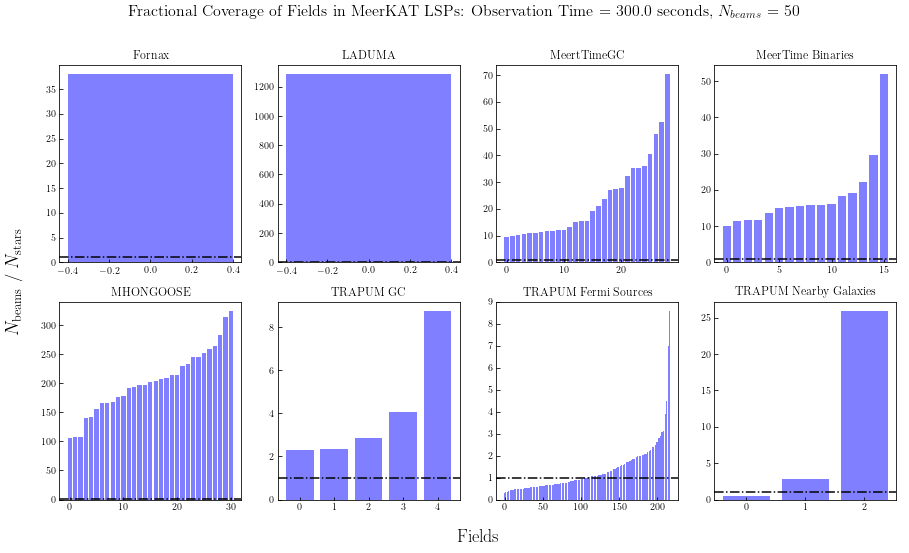

In [27]:
n_beams = 50
obs_time = 300.
k = 0
lsps[6] = 'TRAPUM GC'

fig, axs = plt.subplots(2, 4, figsize=(15,8))
axs = axs.ravel()

for i, group in enumerate(sources_per_group):
    if len(group) > 0:
        axs[k].set_title('{}'.format(lsps[i]))
        axs[k].bar(np.arange(len(group)), alpha = 0.5, color = 'blue',
                   height = np.sort(((times[i] / obs_time) * n_beams) / group))
        axs[k].axhline(1., color = 'black', linestyle = '-.')
        k += 1

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Fields", fontsize = 18, labelpad = 18)
plt.ylabel(r"$N_{\rm beams}$ / $N_{\rm stars}$", fontsize = 18, labelpad = 18)
plt.suptitle(r'Fractional Coverage of Fields in MeerKAT LSPs: ' +
              'Observation Time = {} seconds, $N_{{beams}}$ = {}'.format(obs_time, n_beams)
             , fontsize = 16)
plt.show()
#plt.savefig('survey_coverage.pdf', bbox_inches='tight')


### Beams Needed to Observe Every Source

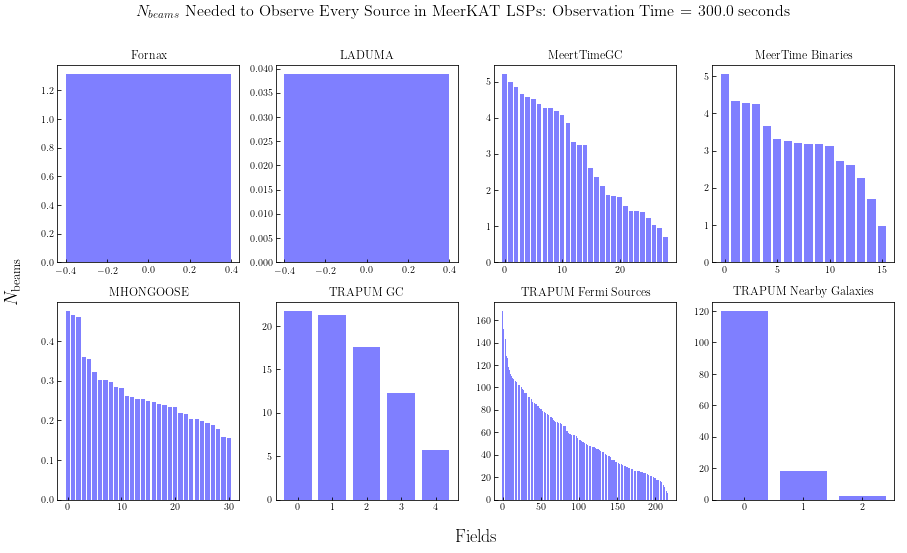

In [28]:
obs_time = 300.
k = 0

fig, axs = plt.subplots(2, 4, figsize=(15,8))
axs = axs.ravel()

for i, group in enumerate(sources_per_group):
    if len(group) > 0:
        axs[k].set_title('{}'.format(lsps[i]))
        idx = np.argsort(((times[i] / obs_time) * n_beams) / group)
        
        axs[k].bar(np.arange(len(group)), alpha = 0.5, color = 'blue',
                   height = (group / (times[i] / obs_time))[idx])
        k += 1

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Fields", fontsize = 18, labelpad = 18)
plt.ylabel(r"$N_{\rm beams}$", fontsize = 18, labelpad = 18)
plt.suptitle(r'$N_{{beams}}$ Needed to Observe Every Source in MeerKAT LSPs: Observation Time = {} seconds'.format(obs_time)
             , fontsize = 16)
plt.show()
#plt.savefig('nbeams_needed_sub.pdf', bbox_inches='tight')


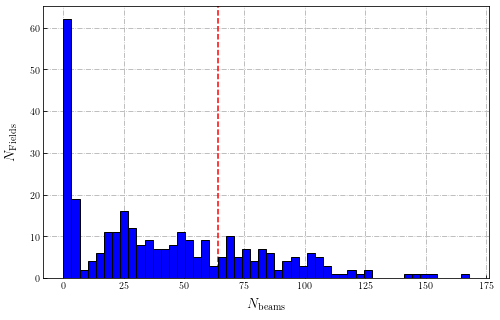

In [77]:
field_list = np.array([item for sublist in sources_per_group for item in sublist])
times_sublist = [[times[i]] * len(sublist) for i, sublist in enumerate(sources_per_group)]
time_list = np.array([item for sublist in times_sublist for item in sublist])
obs_time = 300.

plt.figure(figsize=(8,5))
plt.hist(field_list / (time_list / obs_time), bins = 50,
         alpha = 1, color = 'blue', edgecolor='k', zorder = 3)
plt.xlabel(r"$N_{\rm beams}$", fontsize = 14, labelpad = 10)
plt.ylabel(r"$N_{\rm Fields}$", fontsize = 14, labelpad = 10)
#plt.title(r'Beams Needed to Observe Every Source in Each Field', fontsize = 16)
plt.axvline(x = 64, color = 'red', linestyle = '--')
#plt.yscale('log')
plt.grid(linestyle='dashdot', zorder=0)
plt.savefig('nbeams_needed.png', bbox_inches='tight', dpi = 200)

In [76]:
vals, bins = np.histogram(field_list / (time_list / obs_time), bins = 50)
vals[(bins[:-1] < 64)].sum() / vals.sum()

0.7392739273927392

### Histogram of number of fields with a given number of sources

In [36]:
field_list = [item for sublist in sources_per_group for item in sublist]

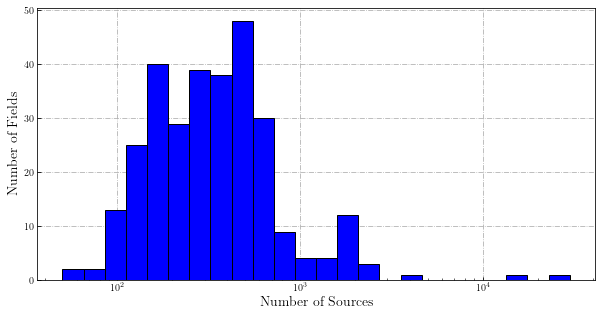

In [37]:
plt.figure(figsize=(10, 5))
plt.hist(field_list, bins = np.logspace(np.log10(50), np.log10(3e4), 25), 
         alpha = 1, color = 'blue', edgecolor='k', zorder = 3)
#plt.hist(flat_list, bins = 50, alpha = 0.5, color = 'blue')
plt.xscale('log')
plt.xlabel('Number of Sources', fontsize=14)
plt.ylabel('Number of Fields', fontsize=14)
plt.grid(linestyle='dashdot', zorder=0)
plt.savefig('source_field_dist.png', bbox_inches='tight', dpi = 200)

In [ ]:
times_sublist = [[times[i]] * len(sublist) for i, sublist in enumerate(sources_per_group)]
time_list = np.array([item for sublist in times_sublist for item in sublist])

plt.figure(figsize=(10, 5))
plt.hist(field_list / time_list, bins = 100, alpha = 1, color = 'blue', edgecolor='k', zorder = 3)
#plt.hist(flat_list, bins = 50, alpha = 0.5, color = 'blue')
#plt.xscale('log')
plt.xlabel(r'$N_{\rm sources}$ / $t_{\rm obs}$', fontsize=14)
plt.ylabel(r'$N_{\rm fields}$', fontsize=14)
plt.grid(linestyle='dashdot', zorder=0)
plt.show()
#plt.savefig('source_field_dist.png', bbox_inches='tight', dpi = 200)

## Time to Observe 1 Million Sources

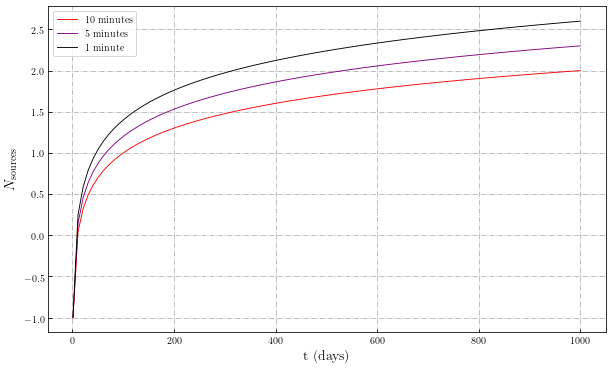

In [77]:
t = np.linspace(1, 1000, 100)

c = ['r', 'purple', 'k']

plt.figure(figsize = (10,6))
plt.plot(t, np.log10(t) - 1, label = '10 beams', color = c[0], linewidth = 0.9)
plt.plot(t, 1.1 * np.log10(t) - 1, label = '50 beams', color = c[1], linewidth = 0.9)
plt.plot(t, 1.2 * np.log10(t) - 1, label = '100 beams', color = c[2], linewidth = 0.9)
plt.xlabel(r't (days)', fontsize=14)
plt.ylabel(r'$N_{\rm sources}$', fontsize=14)
plt.legend()
plt.grid(linestyle='dashdot', zorder=0)
plt.savefig('example_plot_n_beams.png', bbox_inches='tight')

In [ ]:
t = np.linspace(1, 1000, 100)

c = ['r', 'purple', 'k']

plt.figure(figsize = (10,6))
plt.plot(t, np.log10(t) - 1, label = '10 minutes', color = c[0], linewidth = 0.9)
plt.plot(t, 1.1 * np.log10(t) - 1, label = '5 minutes', color = c[1], linewidth = 0.9)
plt.plot(t, 1.2 * np.log10(t) - 1, label = '1 minute', color = c[2], linewidth = 0.9)
plt.xlabel(r't (days)', fontsize=14)
plt.ylabel(r'$N_{\rm sources}$', fontsize=14)
plt.legend()
plt.grid(linestyle='dashdot', zorder=0)
#plt.savefig('example_plot_t_obs.png', bbox_inches='tight')